# Table of Contents


* **Getting Started**: importing/setting up the data
* **The Long Way** : manually doing all the typical steps of pre-processing/training/predicting, using **oo-learning** classes
    * Splitting
    * Transforming
    * Training
    * Predicting
    * Evaluating
* **The Short Way**: presents the **`ModelTrainer`** class, which encapsulates all of the previously mentioned steps.

Note: this notebook is meant to be a demo of some of the capabilities of **`oo-learning`** (https://github.com/shane-kercheval/oo-learning); it is not meant to show the best approach to exploring/cleaning/modeling this particular dataset. Also, with most graphs (e.g. correlations/box-plots/etc.) I will spend very little time commenting on the significance of any interesting or patterns. Again, the intent is to show a demo, not a guide to data analysis. 

# Getting Started

In the last Notebook, https://github.com/shane-kercheval/oo-learning/blob/master/examples/classification-titanic/1-Exploring%20the%20Titanic%20Dataset.ipynb, I showed how to get started and explore the dataset. In this Notebook, we'll look at basic operations like training models, transformations, etc.

## Set Up Environment

In [1]:
# !pip install oolearning --upgrade

In [3]:
from oolearning import *
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

## Import Data

`ExploreRegressionDataset` is a convenience class described in the [first notebook of this series](https://github.com/shane-kercheval/oo-learning/blob/master/examples/regression-insurance/1-Exploring.ipynb).

In [4]:
csv_file = '../data/insurance.csv'
target_variable = 'expenses'

explore = ExploreRegressionDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable)

In [5]:
explore.dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


# The Long Way

The following sections provide a demo of the basic individual classes that are used when training a model. 

In the **`"The Short Way"`** section, next, I demo some of the classes that encapsulate the logic and take care of the mundane and repetitive tasks.  

## Splitting the Data

Let's start out by splitting our data into a training set and holdout set.

To do this, we can use, for example, the **`RegressionStratifiedDataSplitter`**, which as the name suggests, splits the data into training/holdout sets while maintaining a similar distribution (think histogram) of the target variable. Technically, the Splitter will give us the indexes that should go into each set, and we will make the split.

In [6]:
splitter = RegressionStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, holdout_indexes = splitter.split(target_values=explore.dataset.expenses)

In [7]:
training_y = explore.dataset.iloc[training_indexes][target_variable]
training_x = explore.dataset.iloc[training_indexes].drop(columns=target_variable)

holdout_y = explore.dataset.iloc[holdout_indexes][target_variable]
holdout_x = explore.dataset.iloc[holdout_indexes].drop(columns=target_variable)

In [8]:
training_x.shape

(1070, 6)

In [9]:
holdout_x.shape

(268, 6)

Let's check to make sure the Splitter did the other part of its job, which was to split the data in a stratified way, keeping the proportions of the target variable the same.

<AxesSubplot:>

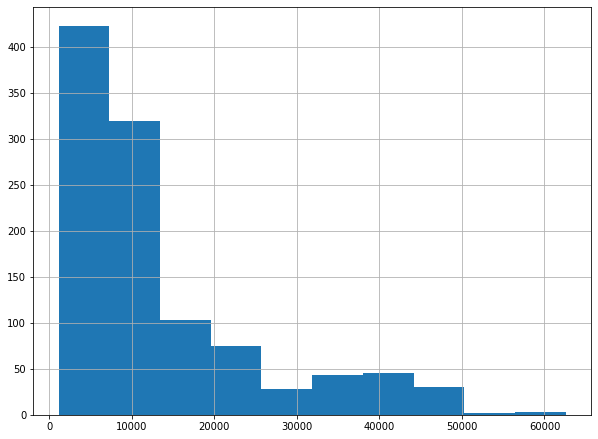

In [10]:
training_y.hist()

<AxesSubplot:>

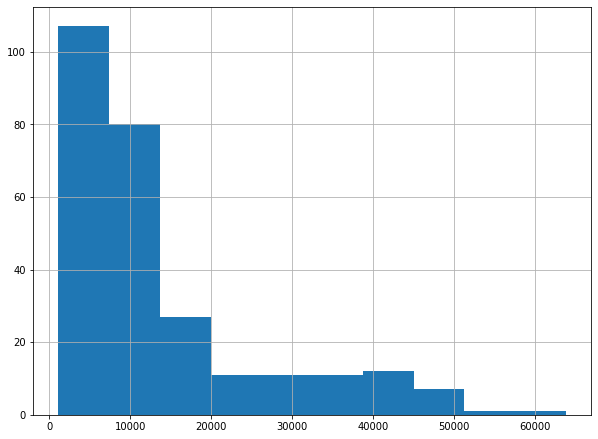

In [11]:
holdout_y.hist()

Pretty close!

## Transforming the Data

Frequently, we need to transform the data before we can train it with various models.

Additionally, we'll want to *fit* transformations on the training set (i.e. the transformation object will extract the necessary attributes from the training set (e.g. median values for each column for a transformer that imputes missing values)) and then apply those same transformations to the holdout set (i.e. use the medians calculated/fitted on the training set, rather than the holdout set).

Let's create a list of transformation objects that we want to apply to the training and holdout sets.

Please see the [classification](http://localhost:8888/notebooks/examples/classification-titanic/2-Basic%20Modeling.ipynb) example for a more elaborate example and additional information.

In [12]:
transformations = [DummyEncodeTransformer(CategoricalEncoding.DUMMY)]  # create dummy variables for categoric features

In order to help manage all of the transformations we want to do (especially when we have more than one transformation object), we'll use the **`TransformerPipeline`** class and fit/transform the training data, then transform (without fitting) the holdout data.

In [13]:
pipeline = TransformerPipeline(transformations=transformations)
transformed_training_data = pipeline.fit_transform(training_x)  # fit & transform
transformed_holdout_data = pipeline.transform(holdout_x)  # fit only

In [14]:
training_x.head()

,age,sex,bmi,children,smoker,region
748,47,female,36.0,1,no,southwest
1085,39,female,18.3,5,yes,southwest
453,20,male,29.7,0,no,northwest
1197,41,male,33.6,0,no,southeast
1187,62,female,32.7,0,no,northwest


In [15]:
transformed_training_data.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
748,47,36.0,1,0,0,0,0,1
1085,39,18.3,5,0,1,0,0,1
453,20,29.7,0,1,0,1,0,0
1197,41,33.6,0,1,0,0,1,0
1187,62,32.7,0,0,0,1,0,0


## Training a Model, & Predicting

Finally, let's train a ridge regression model.

The pattern for training a model includes two classes in most cases. One class specifies the model, in this case **`RidgeRegressor`**, and the other class species the hyper-parameters we want to use in the model. The corresponding class for the Ridge model is **`RidgeRegressorHP`**.

The corresponding **`HP`** classes define the specific parameters that can be tuned, specified in the **`__init__(...)`** function. Instantiating the class without providing any values will result in default values being used.

In most cases, the model classes, such as `RidgeRegressor`, are wrappers around `scikit-learn` classes, and the `HP` classes' default values for the hyper-parameters are the same values that the underlying `scikit-learn` classes use.

In [16]:
model = RidgeRegressor()
model.train(data_x=transformed_training_data, data_y=training_y, hyper_params=RidgeRegressorHP())  # default hyper-parameters

In [17]:
predictions = model.predict(data_x=transformed_holdout_data)
predictions[0:10]

array([11458.05914456, 16751.51316071, 10082.02654326,  2819.86787372,
        6866.39833372,  1582.51586579,  3059.06693566, 13143.38089057,
        3174.52608144,  6986.7094872 ])

## Evaluating Performance

We've trained our model on the training data, and predicted on the holdout. Now we need some way of evaluating performance.

We could use, for example, `scikit-learn`'s MSE or MAE score via `mean_squared_error` or `mean_absolute_error`.

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

math.sqrt(mean_squared_error(y_true=holdout_y, y_pred=predictions))

6077.289804921953

In [19]:
mean_absolute_error(y_true=holdout_y, y_pred=predictions)

4128.425638185533

### **`Evaluator`** object

Great.


But we can also use, for example, `oo-learning`'s **`RegressionEvaluator`** class. This gives us common quality metrics as well as convenient graphs.

In [20]:
evaluator = RegressionEvaluator()
evaluator.evaluate(actual_values=holdout_y, predicted_values=predictions)  # note, we gave it the raw DataFrame, not the converted classes

In [21]:
evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 4128.425638185533,
 'Mean Squared Error (MSE)': 36933451.37300831,
 'Root Mean Squared Error (RMSE)': 6077.289804921953,
 'RMSE to Standard Deviation of Target': 0.49071741180008294,
 'R Squared': 0.7591964217562278,
 'Total Observations': 268}

<AxesSubplot:title={'center':'Residuals vs. Fitted Values'}, xlabel='Fitted Values', ylabel='Residuals (Actual - Predicted)'>

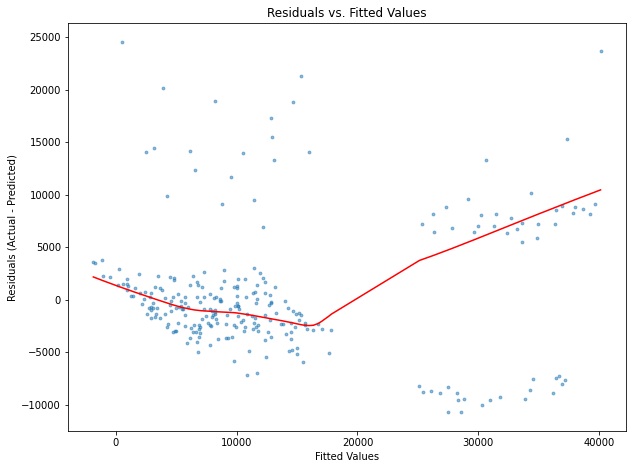

In [22]:
evaluator.plot_residuals_vs_fits()

<AxesSubplot:title={'center':'Predicted Values vs. Actual Values'}, xlabel='Actuals', ylabel='Predicted'>

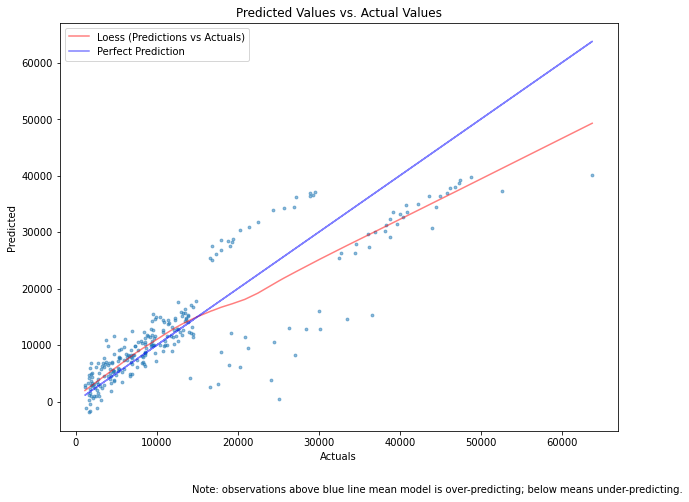

In [23]:
evaluator.plot_predictions_vs_actuals()

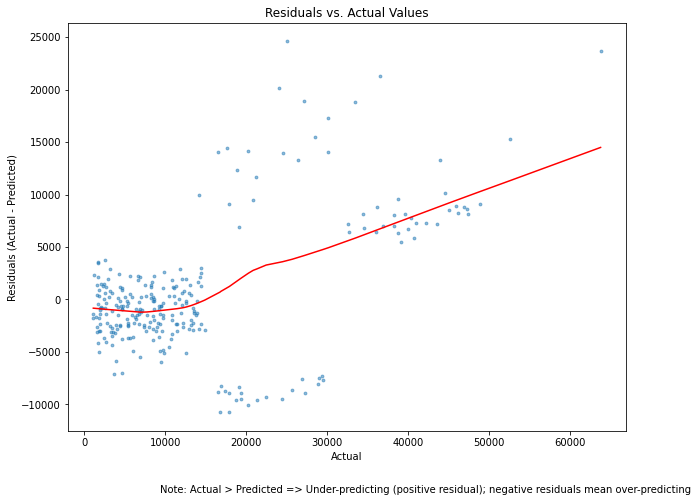

In [24]:
evaluator.plot_residuals_vs_actuals()

# The Short Way


What we did is pretty standard, and we'll probably do the same set of generic steps time and time again.

**`ModelTrainer`** is a class the encapsulate the boring details of what we did, so we can do it a lot quicker and with more concise and descriptive code.

The following code has the identical result as all the work we did above.

In [27]:
trainer = ModelTrainer(model=RidgeRegressor(),
                       model_transformations=[DummyEncodeTransformer(CategoricalEncoding.DUMMY)],
                       splitter= RegressionStratifiedDataSplitter(holdout_ratio=0.2),
                       evaluator=RegressionEvaluator())
trainer.train_predict_eval(data=explore.dataset,
                           target_variable='expenses',
                           hyper_params=RidgeRegressorHP())

# access the holdout metrics (we also have `training_evaluator` available to us as well!) and get a summary
trainer.holdout_evaluator.all_quality_metrics

{'Mean Absolute Error (MAE)': 4128.425638185533,
 'Mean Squared Error (MSE)': 36933451.37300831,
 'Root Mean Squared Error (RMSE)': 6077.289804921953,
 'RMSE to Standard Deviation of Target': 0.49071741180008294,
 'R Squared': 0.7591964217562278,
 'Total Observations': 268}

<AxesSubplot:title={'center':'Residuals vs. Fitted Values'}, xlabel='Fitted Values', ylabel='Residuals (Actual - Predicted)'>

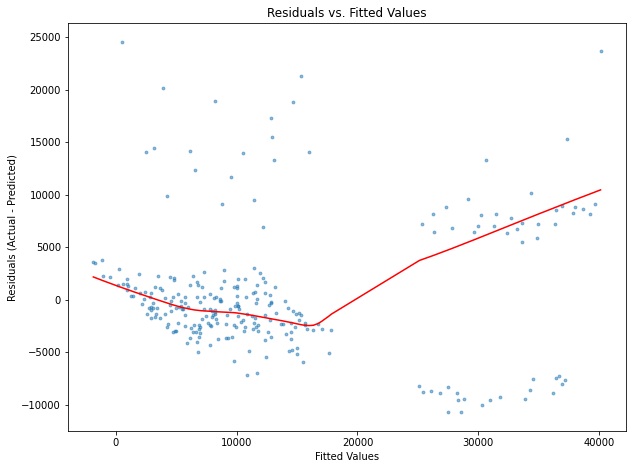

In [28]:
trainer.holdout_evaluator.plot_residuals_vs_fits()